In [1]:
%load_ext autoreload
%autoreload 2

In [74]:
import shap
from sklearn.datasets import make_friedman1
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import accuracy_score, r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
import seaborn as sns
from TreeModelsFromScratch.DecisionTree import DecisionTree
from TreeModelsFromScratch.RandomForest import RandomForest
from TreeModelsFromScratch.SmoothShap import verify_shap_model, smooth_shap, GridSearchCV_scratch, cross_val_score_scratch
from TreeModelsFromScratch.datasets import DATASETS_CLASSIFICATION, DATASETS_REGRESSION, DATASET_PATH
from imodels.util.data_util import get_clean_dataset
import os
from datetime import datetime
import pickle
from tqdm import tqdm, trange
import numbers

In [4]:
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

In [5]:
#load JS vis in the notebook for shap plots
shap.initjs() 

In [6]:
#for storing results
data_path = os.path.join(os.path.dirname(os.getcwd()),"data","null_power_experiment")
today_str = datetime.today().strftime("%Y%m%d")

# Null/power simulations experiment

We replicate the simulation design used by (Strobl et al. 2007) to evaluate the models interpretability by examining their distribution of absolute local SHAP values per feature for the null and power case of the Strobl dataset, and the Friedman1 dataset, respectively. Each model is trained on 100 simulated versions of each dataset, with a fixed number of 100 trees per ensemble. For each of the three regularized RF versions the regularization parameter λ is determined prior to the experiments via 10-fold cross validation on an additional version of the datasets to limit computational effort. <br> 
For the null case of the Strobl dataset, where all features are equally uninformative, we would expect a sensible model to not prioritize one feature over the other. Whereas in the power case of the Strobl dataset as well as for the Friedman1 dataset, we expect a sensible model to clearly distinguish the informative feature(s) from its uninformative counterparts. <br>
As discussed in section 4.3, SHAP values show a bias towards features with high cardinality. Therefore, we do not expect the results for uninformative features to be centered around zero. However, by comparing the same biased FI measure for all models one should still observe a difference in interpretational overfitting between the different models. 

## Strobl datasets

### Define functions

In [8]:
def simulate_data_strobl(n=120, # number of rows in data
                         M=100, # number of simulations
                         relevance = 0.15, # signal srength (0 for NULL)
                         seed=None):
    """Simulate Strobl dataset"""
  
    if isinstance(seed, numbers.Integral) or (seed is None):
        random_state = np.random.RandomState(seed)
    elif isinstance(seed, np.random.RandomState):
        random_state = seed

    x1 = random_state.standard_normal(size=(n,M))
    x2 = random_state.randint(1, 3, size=(n,M))
    x3 = random_state.randint(1, 5, size=(n,M))
    x4 = random_state.randint(1, 11, size=(n,M))
    x5 = random_state.randint(1, 21, size=(n,M))
    X = np.array([x1,x2,x3,x4,x5]).T
      
    y = random_state.binomial(n = 1, p = (0.5 + np.array([-1,1])[x2-1]* relevance))

    return X, y

In [ ]:
def run_strobl_simulation(n=120, M=100, relevance_power=0.15, lambda_dict=None, random_seed=None):
    """Run Strobl experiment for null and power case"""
    
    random_state = np.random.RandomState(random_seed)
    
    X_null, y_null = simulate_data_strobl(n=n, M=M, relevance=0, seed=random_state) #Null simulation
    X_power, y_power = simulate_data_strobl(n=n, M=M, relevance=relevance_power, seed=random_state) #Power simulation

    shap_vals_null = np.empty((4, M, n, X_null.shape[2]))
    shap_vals_power = np.empty((4, M, n, X_power.shape[2]))

    for i in trange(M):
        
        # ----- Null -------
        
        # Null RF: 
        null_rf = RandomForest(n_trees=100, treetype="classification", random_state=random_seed, oob=False)
        null_rf.fit(X_null[i,:,:], y_null[:,i])
        export_rf_null = null_rf.export_forest_for_SHAP()
        explainer_rf_null = shap.TreeExplainer(export_rf_null)
        shap_values_rf_null = explainer_rf_null.shap_values(X_null[i,:,:])
        shap_vals_null[0, i, :, :] = shap_values_rf_null
        
        # Null hsRF: 
        null_rfHS = RandomForest(n_trees=100, treetype="classification", random_state=random_seed, oob=False, HShrinkage=True, HS_lambda=lambda_dict["Null"]["HsRF"])
        null_rfHS.fit(X_null[i,:,:], y_null[:,i])
        export_rfHS_null = null_rfHS.export_forest_for_SHAP()
        explainer_rfHS_null = shap.TreeExplainer(export_rfHS_null)
        shap_values_rfHS_null = explainer_rfHS_null.shap_values(X_null[i,:,:])
        shap_vals_null[1, i, :, :] = shap_values_rfHS_null

        # Null hsRF smooth SHAP: 
        null_rfHSsmSH = RandomForest(n_trees=100, treetype="classification", random_state=random_seed, oob_SHAP=True, HS_smSHAP=True, HS_lambda=lambda_dict["Null"]["AugHS_smSHAP"])
        null_rfHSsmSH.fit(X_null[i,:,:], y_null[:,i])
        export_rfHSsmSH_null = null_rfHSsmSH.export_forest_for_SHAP()
        explainer_rfHSsmSH_null = shap.TreeExplainer(export_rfHSsmSH_null)
        shap_values_rfHSsmSH_null = explainer_rfHSsmSH_null.shap_values(X_null[i,:,:])
        shap_vals_null[2, i, :, :] = shap_values_rfHSsmSH_null
        
        # Null hsRF nodewise MSE: 
        null_rfHSmse = RandomForest(n_trees=100, treetype="classification", random_state=random_seed, oob=True, HS_nodewise_shrink_type="MSE_ratio", HS_lambda=lambda_dict["Null"]["AugHS_mse"])
        null_rfHSmse.fit(X_null[i,:,:], y_null[:,i])
        export_rfHSmse_null = null_rfHSmse.export_forest_for_SHAP()
        explainer_rfHSmse_null = shap.TreeExplainer(export_rfHSmse_null)
        shap_values_rfHSmse_null = explainer_rfHSmse_null.shap_values(X_null[i,:,:])
        shap_vals_null[3, i, :, :] = shap_values_rfHSmse_null
        
        # ----- Power -------
        
        # Power RF: 
        power_rf = RandomForest(n_trees=100, treetype="classification", random_state=random_seed, oob=False)
        power_rf.fit(X_power[i,:,:], y_power[:,i])
        export_rf_power = power_rf.export_forest_for_SHAP()
        explainer_rf_power = shap.TreeExplainer(export_rf_power)
        shap_values_rf_power = explainer_rf_power.shap_values(X_power[i,:,:])
        shap_vals_power[0, i, :, :] = shap_values_rf_power

        # Power hsRF: 
        power_rfHS = RandomForest(n_trees=100, treetype="classification", random_state=random_seed, oob=False, HShrinkage=True, HS_lambda=lambda_dict["Power"]["HsRF"])
        power_rfHS.fit(X_power[i,:,:], y_power[:,i])
        export_rfHS_power = power_rfHS.export_forest_for_SHAP()
        explainer_rfHS_power = shap.TreeExplainer(export_rfHS_power)
        shap_values_rfHS_power = explainer_rfHS_power.shap_values(X_power[i,:,:])
        shap_vals_power[1, i, :, :] = shap_values_rfHS_power

        # Power hsRF smooth SHAP: 
        power_rfHSsmSH = RandomForest(n_trees=100, treetype="classification", random_state=random_seed, oob_SHAP=True, HS_smSHAP=True, HS_lambda=lambda_dict["Power"]["AugHS_smSHAP"])
        power_rfHSsmSH.fit(X_power[i,:,:], y_power[:,i])
        export_rfHSsmSH_power = power_rfHSsmSH.export_forest_for_SHAP()
        explainer_rfHSsmSH_power = shap.TreeExplainer(export_rfHSsmSH_power)
        shap_values_rfHSsmSH_power = explainer_rfHSsmSH_power.shap_values(X_power[i,:,:])
        shap_vals_power[2, i, :, :] = shap_values_rfHSsmSH_power

        # Power hsRF nodewise MSE: 
        power_rfHSmse = RandomForest(n_trees=100, treetype="classification", random_state=random_seed, oob=True, HS_nodewise_shrink_type="MSE_ratio", HS_lambda=lambda_dict["Power"]["AugHS_mse"])
        power_rfHSmse.fit(X_power[i,:,:], y_power[:,i])
        export_rfHSmse_power = power_rfHSmse.export_forest_for_SHAP()
        explainer_rfHSmse_power = shap.TreeExplainer(export_rfHSmse_power)
        shap_values_rfHSmse_power = explainer_rfHSmse_power.shap_values(X_power[i,:,:])
        shap_vals_power[3, i, :, :] = shap_values_rfHSmse_power

    results = {
        "simulation_params":
            {"n": n, 
            "M": M, 
            "relevance_power": relevance_power, 
            "random_seed": random_seed},
        "data": 
            {"X_null": X_null,
            "y_null": y_null,
            "X_power": X_power,
            "y_power": y_power},
        "SHAP_Null": shap_vals_null,
        "SHAP_Power": shap_vals_power}
    
    return results


### Tune hyperparameters on one additional sample for null and power case

In [9]:
# Simulate data
X_null, y_null = simulate_data_strobl(n=120, M=1, relevance=0)
X_power, y_power = simulate_data_strobl(n=120, M=1, relevance=0.15)

Attention: Running the cell below takes very long. You can also import the pickeled results below. 

In [16]:
# GridSearch best hyperparameter lambda
lambdas_dict = {
    "Null":{
        "HsRF":None, 
        "AugHS_smSHAP":None, 
        "AugHS_mse":None},
    "Power":{
        "HsRF":None, 
        "AugHS_smSHAP":None, 
        "AugHS_mse":None}}
cv = 10
grid = {"HS_lambda":[0.1,1,10,25,50,100]}
random_seed = np.random.RandomState(None) # to ensure that all models have the same random seed

## ----- Null ----------
# hsRF: 
null_rfHS = RandomForest(n_trees=100, treetype="classification", random_state=random_seed, oob=False, HShrinkage=True)
grid_cv_HS = GridSearchCV_scratch(null_rfHS, grid, X_null[0,:,:], y_null[:,0], cv=cv, scoring_func=roc_auc_score)
lambdas_dict["Null"]["HsRF"] = null_rfHS.HS_lambda

# AugHsRF smooth SHAP: 
null_rfHSsmSH = RandomForest(n_trees=100, treetype="classification", random_state=random_seed, oob_SHAP=True, HS_smSHAP=True)
grid_cv_HSsmSH = GridSearchCV_scratch(null_rfHSsmSH, grid, X_null[0,:,:], y_null[:,0], cv=cv, scoring_func=roc_auc_score)
lambdas_dict["Null"]["AugHS_smSHAP"] = null_rfHSsmSH.HS_lambda

# AugHsRF MSE: 
null_rfHSmse = RandomForest(n_trees=100, treetype="classification", random_state=random_seed, oob=True, HS_nodewise_shrink_type="MSE_ratio")
grid_cv_HSmse = GridSearchCV_scratch(null_rfHSmse, grid, X_null[0,:,:], y_null[:,0], cv=cv, scoring_func=roc_auc_score)
lambdas_dict["Null"]["AugHS_mse"] = null_rfHSmse.HS_lambda

## ----- Power ----------
# HsRF: 
power_rfHS = RandomForest(n_trees=100, treetype="classification", random_state=random_seed, oob=False, HShrinkage=True)
grid_cv_HS_p = GridSearchCV_scratch(power_rfHS, grid, X_power[0,:,:], y_power[:,0], cv=cv, scoring_func=roc_auc_score)
lambdas_dict["Power"]["HsRF"] = power_rfHS.HS_lambda

# AugHsRF smooth SHAP: 
power_rfHSsmSH = RandomForest(n_trees=100, treetype="classification", random_state=random_seed, oob_SHAP=True, HS_smSHAP=True)
grid_cv_HSsmSH_p = GridSearchCV_scratch(power_rfHSsmSH, grid, X_power[0,:,:], y_power[:,0], cv=cv, scoring_func=roc_auc_score)
lambdas_dict["Power"]["AugHS_smSHAP"] = power_rfHSsmSH.HS_lambda

# Power # AugHsRF MSE: 
power_rfHSmse = RandomForest(n_trees=100, treetype="classification", random_state=random_seed, oob=True, HS_nodewise_shrink_type="MSE_ratio")
grid_cv_HSmse_p = GridSearchCV_scratch(power_rfHSmse, grid, X_power[0,:,:], y_power[:,0], cv=cv, scoring_func=roc_auc_score)
lambdas_dict["Power"]["AugHS_mse"] = power_rfHSmse.HS_lambda

In [ ]:
#store GridCvResults as pickle file
GridCV_results = {"data":{"Null":[X_null, y_null],
                          "Power":[X_power, y_power],},
                  "lambdas": lambdas_dict,
                  "GridCVresults":{
                      "null":{
                        "HsRF":grid_cv_HS, 
                        "AugHS_smSHAP":grid_cv_HSsmSH, 
                        "AugHS_mse":grid_cv_HSmse},
                      "power":{
                        "HsRF":grid_cv_HS_p, 
                        "AugHS_smSHAP":grid_cv_HSsmSH_p, 
                        "AugHS_mse":grid_cv_HSmse_p}}}

with open(f'{data_path}/strobl_GridCV_lambdas.pickle', 'wb') as handle:
    pickle.dump(GridCV_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Run experiment with best lambda value

In [19]:
lambdas_dict

{'Null': {'HsRF': 100, 'AugHS_smSHAP': 0.1, 'AugHS_mse': 25},
 'Power': {'HsRF': 100, 'AugHS_smSHAP': 0.1, 'AugHS_mse': 25}}

Attention: Running the cell below takes very long. You can also import the pickeled results below. 

In [28]:
results_strobl = run_strobl_simulation(n=120, M=100, relevance_power=0.15, lambda_dict=lambdas_dict, random_seed=None)

100%|██████████| 100/100 [2:37:59<00:00, 94.80s/it] 


In [29]:
# store Strobl simulation results as pickle file
with open(f'{data_path}/strobl_results.pickle', 'wb') as handle:
    pickle.dump(results_strobl, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Create plots

In [32]:
results_strobl.keys()

dict_keys(['simulation_params', 'data', 'SHAP_Null', 'SHAP_Power'])

In [45]:
results_strobl["SHAP_Null"].reshape(4,12000,5)[0].shape

(12000, 5)

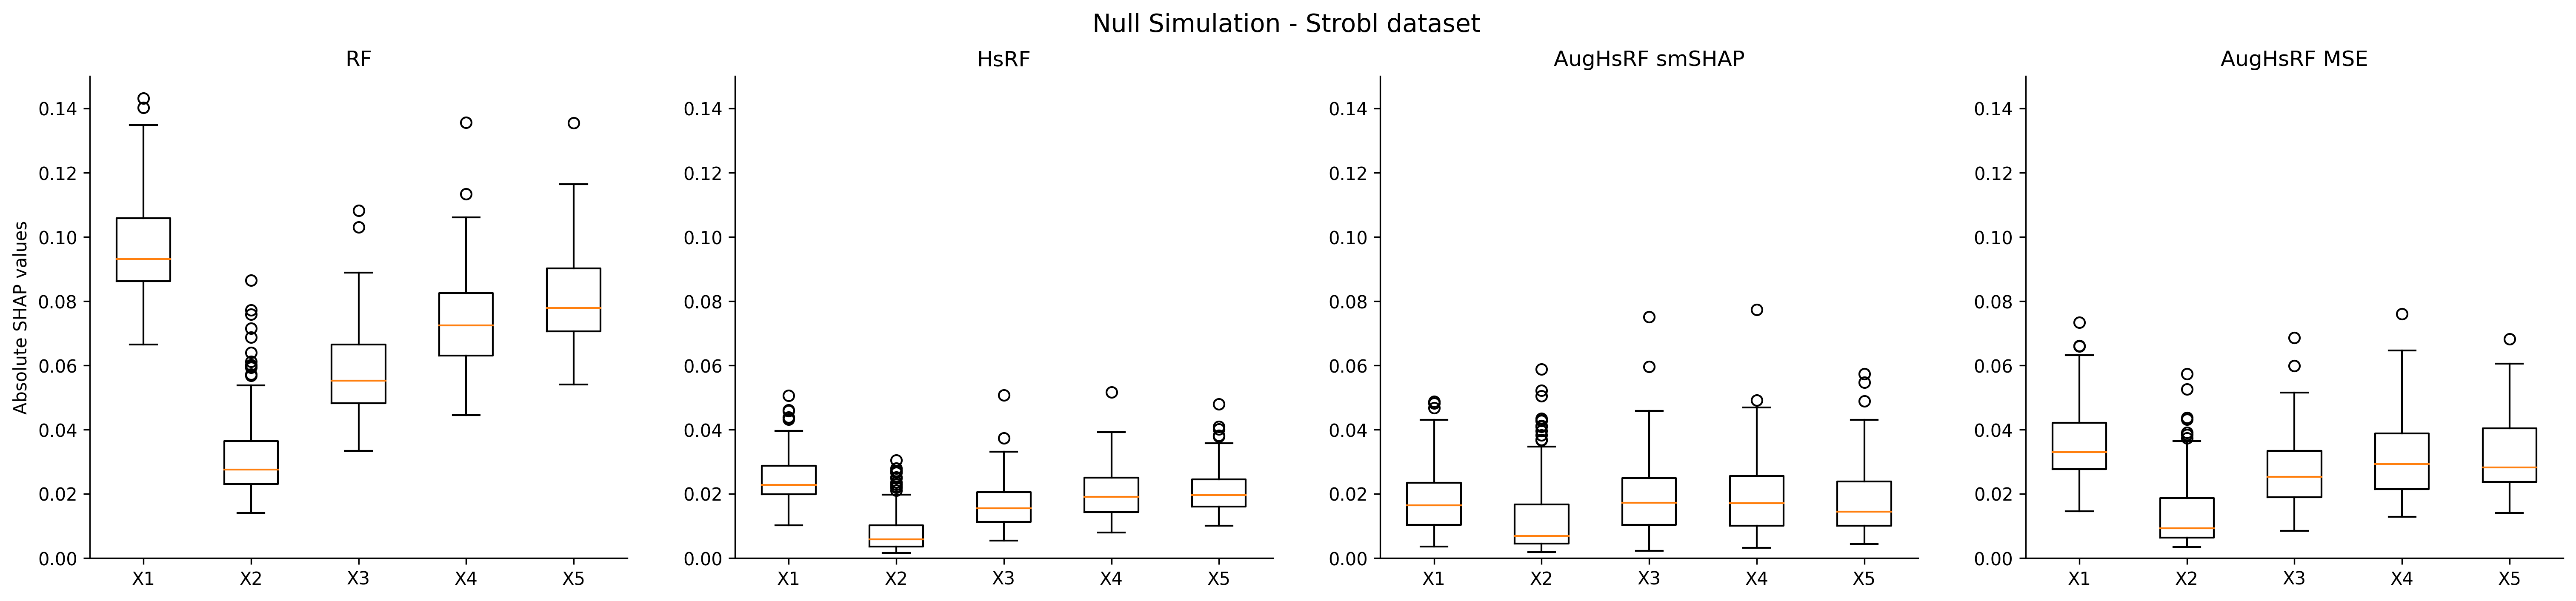

In [68]:
#Null simulation
fig, axs = plt.subplots(1,4, figsize=(25,5))
x_label = ["X1", "X2", "X3", "X4", "X5"]
model_names = ["RF", "HsRF", "AugHsRF smSHAP", "AugHsRF MSE"]
SHAP_null = results_strobl["SHAP_Null"]#.reshape(4,12000,5)

fig.suptitle('Null Simulation - Strobl dataset', fontsize=14)

for i in range(4):
    axs[i].boxplot(np.abs(SHAP_null[i]).mean(axis=1), labels=x_label)
    axs[i].set_title(model_names[i])

axs[0].set_ylabel("Absolute SHAP values")

plt.setp(axs, ylim=[0,0.15]); #set global ylim for all suplots

In [69]:
# Save figure
fig.savefig(f"{data_path}/strobl_null_plots.png")

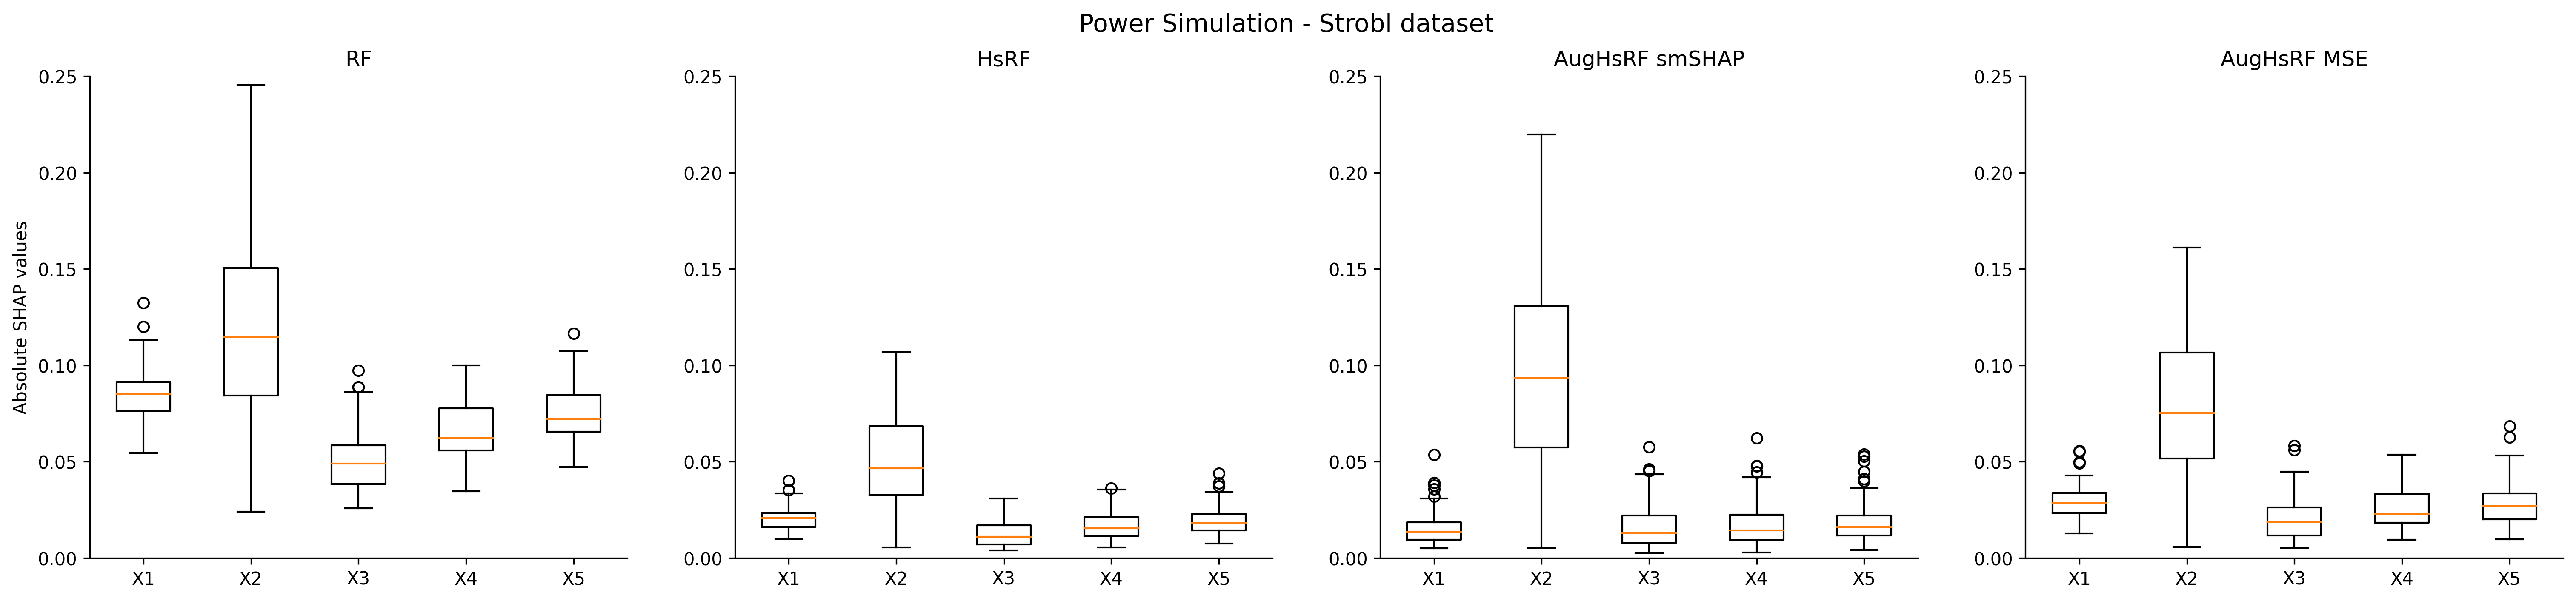

In [70]:
#Power simulation
fig, axs = plt.subplots(1,4, figsize=(25,5))
x_label = ["X1", "X2", "X3", "X4", "X5"]
model_names = ["RF", "HsRF", "AugHsRF smSHAP", "AugHsRF MSE"]
SHAP_power = results_strobl["SHAP_Power"]#.reshape(4,12000,5)

fig.suptitle('Power Simulation - Strobl dataset', fontsize=14)

for i in range(4):
    axs[i].boxplot(np.abs(SHAP_power[i]).mean(axis=1), labels=x_label)
    axs[i].set_title(model_names[i])

axs[0].set_ylabel("Absolute SHAP values")

plt.setp(axs, ylim=[0,0.25]); #set global ylim for all suplots
#fig.tight_layout();

In [71]:
# Save figure
fig.savefig(f"{data_path}/strobl_power_plots.png")

## Friedman 1 dataset (2nd power simulation)

### Define functions

In [72]:
def run_friedman1_simulation(n_samples=200, n_features=10, M=100, noise=0.0, lambda_dict=None, random_seed=None):
    """Run Friedman1 experiment for power case (only first 5 features are informative)"""
    
    random_state = np.random.RandomState(random_seed)

    Xs = np.empty((M, n_samples, n_features))
    ys = np.empty((M, n_samples))

    shap_vals = np.empty((4, M, n_samples, n_features))

    for i in trange(M):
        
        # Create dataset (same simulation settings as in HS paper)
        X, y = make_friedman1(n_samples=n_samples, n_features=n_features, noise=noise)
        Xs[i,:,:] = X
        ys[i,:] = y
        
        # RF: 
        rf = RandomForest(n_trees=100, treetype="regression", random_state=random_seed, oob=False)
        rf.fit(X, y)
        export_rf = rf.export_forest_for_SHAP()
        explainer_rf = shap.TreeExplainer(export_rf)
        shap_values_rf = explainer_rf.shap_values(X)
        shap_vals[0, i, :, :] = shap_values_rf

        # hsRF: 
        rfHS = RandomForest(n_trees=100, treetype="regression", random_state=random_seed, oob=False, HShrinkage=True, HS_lambda=lambda_dict["Power"]["HsRF"])
        rfHS.fit(X, y)
        export_rfHS = rfHS.export_forest_for_SHAP()
        explainer_rfHS = shap.TreeExplainer(export_rfHS)
        shap_values_rfHS = explainer_rfHS.shap_values(X)
        shap_vals[1, i, :, :] = shap_values_rfHS

        # hsRF smooth SHAP: 
        rfHSsmSH = RandomForest(n_trees=100, treetype="regression", random_state=random_seed, oob_SHAP=True, HS_smSHAP=True, HS_lambda=lambda_dict["Power"]["AugHS_smSHAP"])
        rfHSsmSH.fit(X, y)
        export_rfHSsmSH = rfHSsmSH.export_forest_for_SHAP()
        explainer_rfHSsmSH = shap.TreeExplainer(export_rfHSsmSH)
        shap_values_rfHSsmSH = explainer_rfHSsmSH.shap_values(X)
        shap_vals[2, i, :, :] = shap_values_rfHSsmSH

        # hsRF nodewise MSE: 
        rfHSmse = RandomForest(n_trees=100, treetype="regression", random_state=random_seed, oob=True, HS_nodewise_shrink_type="MSE_ratio", HS_lambda=lambda_dict["Power"]["AugHS_mse"])
        rfHSmse.fit(X, y)
        export_rfHSmse = rfHSmse.export_forest_for_SHAP()
        explainer_rfHSmse = shap.TreeExplainer(export_rfHSmse)
        shap_values_rfHSmse = explainer_rfHSmse.shap_values(X)
        shap_vals[3, i, :, :] = shap_values_rfHSmse

    results = {
        "simulation_params":
            {"n_samples":n_samples, 
            "n_features":n_features, 
            "M": M,
            "noise":noise,
            "random_seed": random_seed},
        "data": 
            {"X": Xs,
            "y": ys},
        "SHAP": shap_vals}
    
    return results


### Tune hyperparameters on one additional sample for null and power case

In [75]:
# Simulate data
X, y = make_friedman1(n_samples=200, n_features=10, noise=0.0)

Attention: Running the cell below takes very long. You can also import the pickeled results below. 

In [ ]:
# GridSearch best hyperparameter lambda
frie_lambdas_dict = {
        "HsRF":None, 
        "AugHS_smSHAP":None, 
        "AugHS_mse":None}
cv = 10
grid = {"HS_lambda":[0.1,1,10,25,50,100]}
random_seed = np.random.RandomState(None) # to ensure that all models have the same random seed

# HsRF: 
frie_rfHS = RandomForest(n_trees=100, treetype="regression", random_state=random_seed, oob=False, HShrinkage=True)
frie_grid_cv_HS = GridSearchCV_scratch(frie_rfHS, grid, X, y, cv=cv, scoring_func=r2_score)
frie_lambdas_dict["HsRF"] = frie_rfHS.HS_lambda

# AugHsRF smooth SHAP: 
frie_rfHSsmSH = RandomForest(n_trees=100, treetype="regression", random_state=random_seed, oob_SHAP=True, HS_smSHAP=True)
frie_grid_cv_HSsmSH = GridSearchCV_scratch(frie_rfHSsmSH, grid, X, y, cv=cv, scoring_func=r2_score)
frie_lambdas_dict["AugHS_smSHAP"] = frie_rfHSsmSH.HS_lambda

# AugHsRF MSE: 
frie_rfHSmse = RandomForest(n_trees=100, treetype="regression", random_state=random_seed, oob=True, HS_nodewise_shrink_type="MSE_ratio")
frie_grid_cv_HSmse = GridSearchCV_scratch(frie_rfHSmse, grid, X, y, cv=cv, scoring_func=r2_score)
frie_lambdas_dict["AugHS_mse"] = frie_rfHSmse.HS_lambda

In [ ]:
# store GridCvResults as pickle file
GridCV_results = {"data":{"Null":[X_null, y_null],
                          "Power":[X_power, y_power],},
                  "lambdas": lambdas_dict,
                  "GridCVresults":{
                        "HsRF":frie_grid_cv_HS, 
                        "AugHS_smSHAP":frie_grid_cv_HSsmSH, 
                        "AugHS_mse":frie_grid_cv_HSmse}}

with open(f'{data_path}/friedman1_GridCV_lambdas.pickle', 'wb') as handle:
    pickle.dump(GridCV_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Run experiment with best lambda value

In [ ]:
frie_lambdas_dict

{'Null': {'HsRF': 100, 'AugHS_smSHAP': 0.1, 'AugHS_mse': 25},
 'Power': {'HsRF': 100, 'AugHS_smSHAP': 0.1, 'AugHS_mse': 25}}

Attention: Running the cell below takes very long. You can also import the pickeled results below. 

In [ ]:
results_friedman1 = run_friedman1_simulation(n_samples=200, n_features=10, M=100, noise=0.0, lambda_dict=None, random_seed=None)

100%|██████████| 100/100 [2:37:59<00:00, 94.80s/it] 


In [ ]:
# store Strobl simulation results as pickle file
with open(f'{data_path}/friedman1_results.pickle', 'wb') as handle:
    pickle.dump(results_friedman1, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Create plots

In [ ]:
#Friedman1 power case 
fig, axs = plt.subplots(1,4, figsize=(15,4))
x_label = [f"X{i}" for i in range(1,11)]
model_names = ["RF", "HsRF", "AugHsRF smSHAP", "AugHsRF MSE"]
SHAP = results_friedman1["SHAP"]

fig.suptitle('Friedman1', fontsize=14)

for i in range(4):
    axs[i].boxplot(np.abs(SHAP[i]), labels=x_label)
    axs[i].set_title(model_names[i])

axs[0].set_ylabel("Absolute SHAP values")

#plt.setp(axs, ylim=[0,0.15]) #set global ylim for all suplots
#fig.tight_layout();

In [ ]:
# Save figure
fig.savefig(f"{data_path}/friedman1_plots.png")